In [1]:
import os 
import pickle
import numpy as np
from os.path import join  

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.distribute import MirroredStrategy

datasets = join(os.getcwd(), "datasets")
preprocessed_datasets = join(datasets, "preprocessed")

X_all, y_all, X_test = pickle.load(open(join(preprocessed_datasets, "cleaned_ohe.pickle"), 'rb'))
X_train, X_val, y_train, y_val = train_test_split(X_all, y_all, shuffle=True, train_size=.75, random_state=42)

strategy = MirroredStrategy(["GPU:0", "GPU:1"])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


In [2]:
class BCR(tf.keras.metrics.Metric):
    def __init__(self, name='BCR', dtype=None):
        super().__init__(name, dtype=dtype)
        self.TP = tf.keras.metrics.TruePositives()
        self.TN = tf.keras.metrics.TrueNegatives()
        self.FP = tf.keras.metrics.FalsePositives()
        self.FN = tf.keras.metrics.FalseNegatives()
        
        self.bcr = self.add_weight(name='bcr', initializer='zeros')
    
    def update_state(self, y_true, y_pred, sample_weight=None):
        
        self.TP.update_state(y_true, y_pred)
        self.TN.update_state(y_true, y_pred)
        self.FP.update_state(y_true, y_pred)
        self.FN.update_state(y_true, y_pred)
        
        tp = self.TP.result() 
        tn = self.TN.result()
        fp = self.FP.result()
        fn = self.FN.result()
        
        self.bcr.assign(.5 * ((tp / (tp + fn)) + (tn / (fp + tn))))
    
    def result(self):
        return self.bcr
        
    def reset_states(self):
        self.bcr.assign(0.0)


def recall(y_true, y_pred):
    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return tp / (possible_positives + K.epsilon())

def specificity(y_true, y_pred):
    tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    fp = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
    return tn / (tn + fp + K.epsilon())

def bcr(y_true, y_pred):
    return .5 * (recall(y_true, y_pred) + specificity(y_true, y_pred))

def p1(y_true, y_pred):
    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    m = m1(y_true, y_pred)
    return tp / (m + K.epsilon())

def p2(y_true, y_pred):
    tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    m = m2(y_true, y_pred)
    return tn / (m + K.epsilon())

def m1(y_true, y_pred):
    return K.sum(K.round(y_true))

def m2(y_true, y_pred):
    return K.sum(K.round(K.clip(1 - y_true, 0, 1)))

def P(bcr, bcr_hat, p1, p2, m1, m2):
    bcr_delta = np.abs(bcr - bcr_hat)
    sigma = .5 * np.sqrt(((1-p1)*p1/m1) + (p2*(1-p2)/m2))
    return bcr - bcr_delta * (1 - np.exp(- bcr_delta / sigma))

def P_model(model, X_train, y_train, X_val, y_val, with_info=False):
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    
    bcr_ = bcr(y_train, y_train_pred)
    bcr_hat = bcr(y_val, y_val_pred)
    
    p1_ = p1(y_val, y_val_pred)
    p2_ = p2(y_val, y_val_pred)
    m1_ = m1(y_val, y_val_pred)
    m2_ = m2(y_val, y_val_pred)
    
    p = P(bcr_, bcr_hat, p1_, p2_, m1_, m2_)
    
    if with_info:
        return p, {'bcr':bcr_, 'bcr_hat':bcr_hat, 'p1':p1_, 'p2':p2_, 'm1':m1_, 'm2':m2_}
    
    return p
    

class BCREarlyStopping(keras.callbacks.Callback):
    """Stop training when the loss is at its min, i.e. the loss stops decreasing.

      Arguments:
          patience: Number of epochs to wait after min has been hit. After this
          number of no improvement, training stops.
      """

    def __init__(self, patience=0, restore_best_weights=False):
        super(BCREarlyStopping, self).__init__()
        self.patience = patience
        self.restore_best_weights = restore_best_weights
        # best_weights to store the weights at which the minimum loss occurs.
        self.best_weights = None

    def on_train_begin(self, logs=None):
        # The number of epoch it has waited when loss is no longer minimum.
        self.wait = 0
        # The epoch the training stops at.
        self.stopped_epoch = 0
        # Initialize the best as infinity.
        self.best = .0
        
    def on_epoch_end(self, epoch, logs=None):
        bcr = logs.get("bcr")
        val_bcr = logs.get("val_bcr")
        p1 = logs.get("val_p1")
        p2 = logs.get("val_p2")
        m1 = logs.get("val_m1")
        m2 = logs.get("val_m2")
        current = P(bcr, val_bcr, p1, p2, m1, m2)
        
        if np.less(self.best, current):
            print(f"New best p value : {current}")
            self.best = current
            self.wait = 0
            # Record the best weights if current results is better (less).
            self.best_weights = self.model.get_weights()
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                if self.restore_best_weights:
                    print(f"Restoring model weights from the end of the best epoch. Best value : {self.best:.3f}")
                    self.model.set_weights(self.best_weights)

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print("Epoch %05d: early stopping" % (self.stopped_epoch + 1))


In [3]:
with strategy.scope():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(X_train.shape[1],)),
        tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.L1(0.01), activation='sigmoid')
    ])
    
    model.compile(
        loss=tf.keras.losses.BinaryCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(lr=1e-3),
        metrics=[bcr, p1, p2, m1, m2, "accuracy"]
    )

callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_bcr', factor=.5, patience=10, verbose=2),
    BCREarlyStopping(patience=30, restore_best_weights=True)
]

model.summary()

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 1306757   
Total params: 1,306,757
Trainable params: 1,306,757
Non-trainable params: 0
_________________________________________________________________


In [4]:
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    batch_size=120,
                    epochs=1000,
                    callbacks=callbacks,
                   )

Epoch 1/200
INFO:tensorflow:batch_all_reduce: 2 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:batch_all_reduce: 2 all-reduces with algorithm 

/home/romaingrx/anaconda3/envs/ingi2262/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: divide by zero encountered in double_scalars


2/2 [==============================] - 0s 376ms/step - loss: 2299.0192 - bcr: 0.5000 - p1: 1.0000 - p2: 0.0000e+00 - m1: 25.1667 - m2: 34.6667 - accuracy: 0.4197 - val_loss: 870.2086 - val_bcr: 0.5000 - val_p1: 0.0000e+00 - val_p2: 1.0000 - val_m1: 11.0000 - val_m2: 28.0000 - val_accuracy: 0.7179
Epoch 3/200
1/2 [==============>...............] - ETA: 0s - loss: 1256.2146 - bcr: 0.5000 - p1: 0.0000e+00 - p2: 1.0000 - m1: 26.5000 - m2: 37.5000 - accuracy: 0.5859

/home/romaingrx/anaconda3/envs/ingi2262/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in double_scalars


2/2 [==============================] - 0s 377ms/step - loss: 1538.5776 - bcr: 0.5000 - p1: 0.0000e+00 - p2: 1.0000 - m1: 24.5000 - m2: 35.3333 - accuracy: 0.5907 - val_loss: 1807.3362 - val_bcr: 0.5000 - val_p1: 0.0000e+00 - val_p2: 1.0000 - val_m1: 11.0000 - val_m2: 28.0000 - val_accuracy: 0.7179
Epoch 4/200
2/2 [==============================] - 0s 391ms/step - loss: 2481.9868 - bcr: 0.5000 - p1: 0.0000e+00 - p2: 1.0000 - m1: 23.3333 - m2: 36.5000 - accuracy: 0.6089 - val_loss: 1410.2219 - val_bcr: 0.5000 - val_p1: 0.0000e+00 - val_p2: 1.0000 - val_m1: 11.0000 - val_m2: 28.0000 - val_accuracy: 0.7179
Epoch 5/200
2/2 [==============================] - 0s 387ms/step - loss: 1872.8149 - bcr: 0.5000 - p1: 0.0000e+00 - p2: 1.0000 - m1: 25.3333 - m2: 34.5000 - accuracy: 0.5777 - val_loss: 248.9332 - val_bcr: 0.5812 - val_p1: 0.2946 - val_p2: 0.8677 - val_m1: 11.0000 - val_m2: 28.0000 - val_accuracy: 0.7051
Epoch 6/200
2/2 [==============================] - 0s 369ms/step - loss: 555.0507 - 

Epoch 29/200
2/2 [==============================] - 0s 375ms/step - loss: 42.2785 - bcr: 0.8160 - p1: 0.8740 - p2: 0.7579 - m1: 24.8333 - m2: 35.0000 - accuracy: 0.8171 - val_loss: 67.6332 - val_bcr: 0.6420 - val_p1: 0.4286 - val_p2: 0.8555 - val_m1: 11.0000 - val_m2: 28.0000 - val_accuracy: 0.7308

Epoch 00029: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 30/200
2/2 [==============================] - 0s 377ms/step - loss: 37.4773 - bcr: 0.8417 - p1: 0.7227 - p2: 0.9607 - m1: 23.6667 - m2: 36.1667 - accuracy: 0.8654 - val_loss: 65.7372 - val_bcr: 0.6420 - val_p1: 0.4286 - val_p2: 0.8555 - val_m1: 11.0000 - val_m2: 28.0000 - val_accuracy: 0.7308
Epoch 31/200
2/2 [==============================] - 1s 394ms/step - loss: 31.4941 - bcr: 0.8618 - p1: 0.7737 - p2: 0.9499 - m1: 24.0000 - m2: 35.8333 - accuracy: 0.8720 - val_loss: 75.6224 - val_bcr: 0.7194 - val_p1: 0.7679 - val_p2: 0.6710 - val_m1: 11.0000 - val_m2: 28.0000 - val_accuracy: 0.7051
New best p value : 

2/2 [==============================] - 0s 380ms/step - loss: 13.3725 - bcr: 0.9398 - p1: 0.9221 - p2: 0.9574 - m1: 24.1667 - m2: 35.6667 - accuracy: 0.9437 - val_loss: 47.2282 - val_bcr: 0.7484 - val_p1: 0.6696 - val_p2: 0.8271 - val_m1: 11.0000 - val_m2: 28.0000 - val_accuracy: 0.7821
Epoch 56/200
2/2 [==============================] - 0s 388ms/step - loss: 13.6650 - bcr: 0.9336 - p1: 0.9159 - p2: 0.9513 - m1: 24.6667 - m2: 35.1667 - accuracy: 0.9388 - val_loss: 47.6728 - val_bcr: 0.7582 - val_p1: 0.7054 - val_p2: 0.8110 - val_m1: 11.0000 - val_m2: 28.0000 - val_accuracy: 0.7821
Epoch 57/200
2/2 [==============================] - 0s 377ms/step - loss: 13.0806 - bcr: 0.9447 - p1: 0.9430 - p2: 0.9465 - m1: 24.0000 - m2: 35.8333 - accuracy: 0.9443 - val_loss: 47.5137 - val_bcr: 0.7582 - val_p1: 0.7054 - val_p2: 0.8110 - val_m1: 11.0000 - val_m2: 28.0000 - val_accuracy: 0.7821
Epoch 58/200
2/2 [==============================] - 0s 386ms/step - loss: 13.5984 - bcr: 0.9444 - p1: 0.9416 - p2

/home/romaingrx/anaconda3/envs/ingi2262/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Legend does not support 'ss' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


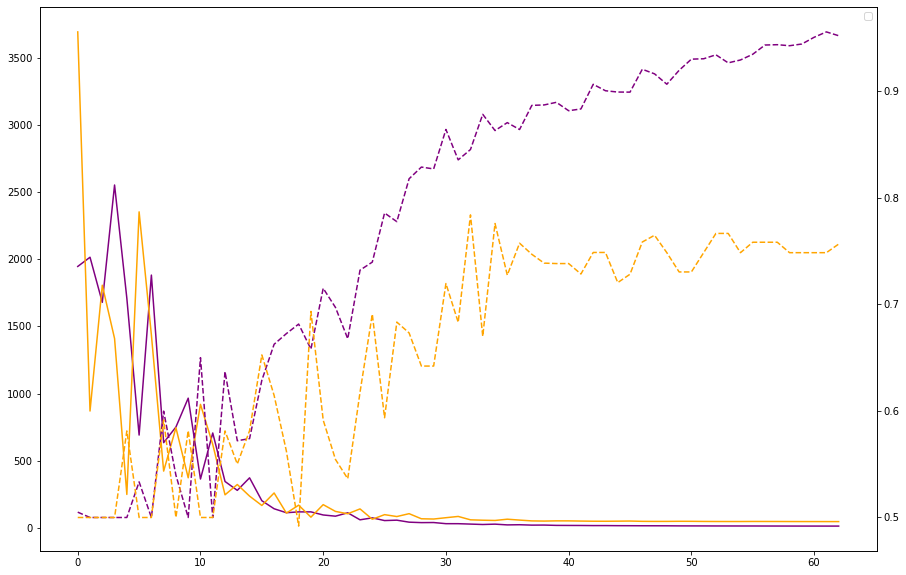

In [21]:
import matplotlib.pyplot as plt

# history = history.history
epochs_ = np.arange(len(history['loss']))

fig = plt.figure(figsize=(15, 10))
plt.title("")
axL = plt.gca()
axR = axL.twinx()

p1 = axL.plot(epochs_, history['loss'], label='loss', color='purple', ls='-')
p2 = axL.plot(epochs_, history['val_loss'], label='val_loss', color='orange', ls='-')

p3 = axR.plot(epochs_, history['bcr'], label='bcr', color='purple', ls='--')
p4 = axR.plot(epochs_, history['val_bcr'], label='val_bcr', color='orange', ls='--')

_ = plt.legend(["ss"]*4, [p1, p2, p3, p4])

Get the performance of the model
---

In [5]:
from utils import Report

report = Report(model, X_train, y_train, X_val, y_val).to_stdout()

------------------ Report for Sequential -------------------

P score : 0.800
BCR     : 0.875
BCR hat : 0.783


Save the csv output and model
---

In [6]:
from utils import to_contest_csv

y_test = model.predict(X_test).round().astype(np.uint8).flatten()

# report.to_contest_csv(f"dnn_linear_{report.p.numpy():.3f}", y_test, save_model=True)